## MEDI-TRACK-GPT

In [6]:
# Replace with your actual GitHub repo URL
!git clone https://github.com/Darshan-Deepak/Medi-Track-GPT.git


Cloning into 'Medi-Track-GPT'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 41 (delta 14), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 2.26 MiB | 2.46 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [7]:
%cd Medi-Track-GPT


/content/Medi-Track-GPT


# Phase 1

In [1]:
!pip uninstall -y transformers
!pip install -U transformers==4.52.4


Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
Using cached transformers-4.52.4-py3-none-any.whl (10.5 MB)


In [2]:
import transformers
print(transformers.__version__)  # 🔍 Make sure this shows 4.52.4


4.52.4


In [3]:
import transformers
print(transformers.__version__)
print(transformers.__file__)


4.52.4
/usr/local/lib/python3.11/dist-packages/transformers/__init__.py


In [4]:
import pandas as pd
from pathlib import Path

In [9]:
import pandas as pd
from pathlib import Path

# Set the data path
# Correct the path to the data directory after cloning the repository
data_dir = Path("/content/Medi-Track-GPT/data/ehr")

# Load the Synthea CSV files
patients = pd.read_csv(data_dir / "patients.csv")
encounters = pd.read_csv(data_dir / "encounters.csv")
conditions = pd.read_csv(data_dir / "conditions.csv")
observations = pd.read_csv(data_dir / "observations.csv")

print("Loaded:", len(patients), "patients")
print("Loaded:", len(encounters), "encounters")

Loaded: 116 patients
Loaded: 7366 encounters


In [10]:
# Reuse this function to simulate a doctor's discharge summary
def generate_discharge_note(encounter_row):
    encounter_id = encounter_row['Id']
    patient_id = encounter_row['PATIENT']
    reason = encounter_row['DESCRIPTION']

    # Get diagnoses
    diag_rows = conditions[conditions['ENCOUNTER'] == encounter_id]
    diagnoses = ", ".join(diag_rows['DESCRIPTION'].tolist()) or "No diagnosis available"

    # Get vitals
    vitals_rows = observations[observations['ENCOUNTER'] == encounter_id]
    vitals_text = ""
    for _, row in vitals_rows.iterrows():
        unit = row['UNIT'] if 'UNIT' in row else ''
        vitals_text += f"- {row['DESCRIPTION']}: {row['VALUE']} {unit}\n"


    note = f"""
    Discharge Summary
    ------------------
    Encounter ID: {encounter_id}
    Patient ID: {patient_id}
    Reason for Visit: {reason}
    Diagnoses: {diagnoses}

    Key Vitals:
    {vitals_text if vitals_text else 'No vitals recorded'}

    Plan:
    - Discharge with medications as prescribed.
    - Follow-up in 2 weeks.
    - If symptoms worsen, return to hospital immediately.
    """.strip()

    return note


In [11]:
Path("data/ehr").mkdir(parents=True, exist_ok=True)

In [20]:
# Create summaries for the first 50 encounters
summaries = []
for i, row in encounters.head(200).iterrows():
    summary = generate_discharge_note(row)
    summaries.append({'encounter_id': row['Id'], 'summary': summary})

# Save to CSV for GPT input
summary_df = pd.DataFrame(summaries)
summary_df.to_csv("data/ehr/discharge_summaries.csv", index=False)
summary_df.head(3)


,encounter_id,summary
0,40f237cc-477c-6442-3e33-7e872da13ba7,Discharge Summary\n ------------------\n ...
1,f21d1bba-2a97-4b5d-6063-06dc8d8c610e,Discharge Summary\n ------------------\n ...
2,7b2e8293-5681-eea9-5e10-81b11b5d86cc,Discharge Summary\n ------------------\n ...


# Phase 2

In [16]:
!pip install transformers accelerate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 755.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.5 MB/s eta 0:00:00


In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load tokenizer and model
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # We'll define our labels

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
# You can update these based on real clinical triage logic
label_map = {
    0: "Low Risk",
    1: "Moderate Risk",
    2: "High Risk"
}


In [24]:

df = pd.read_csv("/content/Medi-Track-GPT/notebooks/data/ehr/discharge_summaries.csv")

print("Loaded", len(df), "summaries")

Loaded 50 summaries


In [25]:
def predict_triage(summary):
    inputs = tokenizer(summary, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = F.softmax(logits, dim=1)
    pred_label = torch.argmax(probs).item()
    return label_map[pred_label], probs[0][pred_label].item()


In [26]:
results = []

for _, row in df.iterrows():
    label, confidence = predict_triage(row.summary)
    results.append({
        "summary": row.summary,
        "triage_label": label,
        "confidence": round(confidence, 4)
    })

triage_df = pd.DataFrame(results)
triage_df.to_csv("data/ehr/triage_predictions_biobert.csv", index=False)
triage_df.head()


,summary,triage_label,confidence
0,Discharge Summary\n ------------------\n ...,High Risk,0.4622
1,Discharge Summary\n ------------------\n ...,High Risk,0.4535
2,Discharge Summary\n ------------------\n ...,High Risk,0.4504
3,Discharge Summary\n ------------------\n ...,High Risk,0.4660
4,Discharge Summary\n ------------------\n ...,High Risk,0.5110


In [27]:
# Load the labeled dataset
df = pd.read_csv("data/ehr/triage_predictions_biobert.csv")

# Optional: Standardize labels
df["triage_label"] = df["triage_label"].replace({
    "Low Risk": "Low",
    "Moderate Risk": "Medium",
    "High Risk": "High"
})

# Label encoding
label_map = {"Low": 0, "Medium": 1, "High": 2}
df["label"] = df["triage_label"].map(label_map)

df = df[["summary", "label"]]
df.head()

,summary,label
0,Discharge Summary\n ------------------\n ...,2
1,Discharge Summary\n ------------------\n ...,2
2,Discharge Summary\n ------------------\n ...,2
3,Discharge Summary\n ------------------\n ...,2
4,Discharge Summary\n ------------------\n ...,2


In [28]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["summary"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)


In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=512
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=512
)

In [30]:
import torch

class TriageDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {"labels": torch.tensor(self.labels[idx])}

train_dataset = TriageDataset(train_encodings, train_labels)
val_dataset = TriageDataset(val_encodings, val_labels)


In [31]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    num_labels=3
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # or evaluation_strategy depending on your version
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # ✅ disables wandb, tensorboard, etc.
)


In [33]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,0.379500,0.052529
2,0.033600,0.016352


Epoch,Training Loss,Validation Loss
1,0.379500,0.052529
2,0.033600,0.016352
3,0.015800,0.011294


TrainOutput(global_step=30, training_loss=0.1429609497388204, metrics={'train_runtime': 921.1089, 'train_samples_per_second': 0.13, 'train_steps_per_second': 0.033, 'total_flos': 31573610127360.0, 'train_loss': 0.1429609497388204, 'epoch': 3.0})

In [34]:
model.save_pretrained("triage-biobert-model")
tokenizer.save_pretrained("triage-biobert-model")


('triage-biobert-model/tokenizer_config.json',
 'triage-biobert-model/special_tokens_map.json',
 'triage-biobert-model/vocab.txt',
 'triage-biobert-model/added_tokens.json',
 'triage-biobert-model/tokenizer.json')

In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load model
model = AutoModelForSequenceClassification.from_pretrained("triage-biobert-model")
tokenizer = AutoTokenizer.from_pretrained("triage-biobert-model")

# Example summary
text = "Discharge Summary\n------------------------\nEncounter ID: ...\nDiagnoses: Pneumonia\n..."

# Tokenize input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Predict
with torch.no_grad():
    logits = model(**inputs).logits
    probs = F.softmax(logits, dim=1)
    label_id = torch.argmax(probs).item()
    confidence = probs[0][label_id].item()

# Map label index to string
label_map = {0: "Low Risk", 1: "Moderate Risk", 2: "High Risk"}
print("Predicted Label:", label_map[label_id])
print("Confidence:", round(confidence, 3))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted Label: High Risk
Confidence: 0.986


In [36]:
print(df.columns)


Index(['summary', 'label'], dtype='object')


In [37]:
results = []
for _, row in df.iterrows():
    label, confidence = predict_triage(row["summary"])  # updated model prediction
    results.append({
        "summary": row["summary"],
        "triage_label": label,
        "confidence": round(confidence, 3)
    })

triage_df = pd.DataFrame(results)
triage_df.to_csv("data/ehr/triage_predictions_finetuned.csv", index=False)
triage_df.head()


,summary,triage_label,confidence
0,Discharge Summary\n ------------------\n ...,High Risk,0.989
1,Discharge Summary\n ------------------\n ...,High Risk,0.989
2,Discharge Summary\n ------------------\n ...,High Risk,0.989
3,Discharge Summary\n ------------------\n ...,High Risk,0.989
4,Discharge Summary\n ------------------\n ...,High Risk,0.988


<ipython-input-38-725106231>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=triage_df, x="triage_label", palette="Set2")


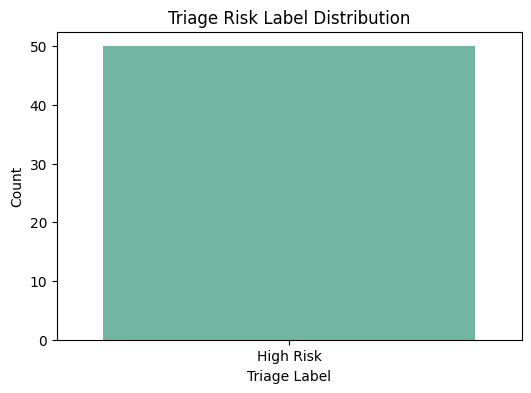

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot
plt.figure(figsize=(6, 4))
sns.countplot(data=triage_df, x="triage_label", palette="Set2")
plt.title("Triage Risk Label Distribution")
plt.xlabel("Triage Label")
plt.ylabel("Count")
plt.show()


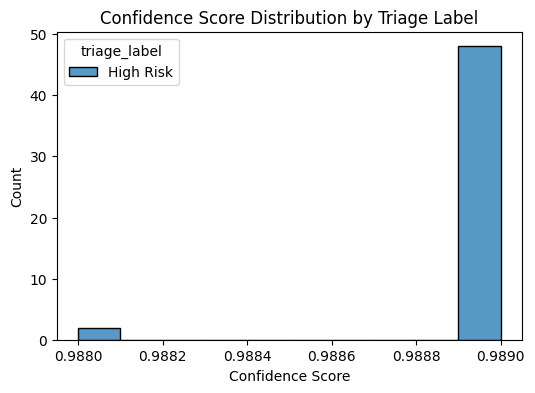

In [39]:
plt.figure(figsize=(6, 4))
sns.histplot(data=triage_df, x="confidence", bins=10, hue="triage_label", multiple="stack")
plt.title("Confidence Score Distribution by Triage Label")
plt.xlabel("Confidence Score")
plt.ylabel("Count")
plt.show()


In [40]:
top_risks = triage_df.sort_values(by="confidence", ascending=False).head(3)
top_risks[["summary", "triage_label", "confidence"]]


,summary,triage_label,confidence
0,Discharge Summary\n ------------------\n ...,High Risk,0.989
1,Discharge Summary\n ------------------\n ...,High Risk,0.989
2,Discharge Summary\n ------------------\n ...,High Risk,0.989
